# Modelling BG

## Model Shapping

In [5]:
import numpy as np
import os
import pandas as pd
from pipelines import pipeline

train_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(train_data_file, index_col=0, low_memory=False)
additional_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_5h.csv')
additional_data = pd.read_csv(additional_data_file, low_memory=False)

# merge train and additional data
train_data = pd.concat([train_data, additional_data], axis=0)

# read validation data
validation_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_3h.csv')
validation_data = pd.read_csv(validation_data_file, low_memory=False)

# do not train with patients that are not have to be predicted
unique_patients = validation_data['p_num'].unique()
train_data = train_data[train_data['p_num'].isin(unique_patients)]

train_data_processed = pipeline.fit_transform(train_data)
validation_data_processed = pipeline.transform(validation_data)

## Train XGBoost model

In [4]:
# Load and preprocess the train data 
from src.features.tuners import XGBHyperparameterTuner
from sklearn.metrics import root_mean_squared_error

train_and_validation_data = pd.concat([train_data_processed, validation_data_processed])

X = train_and_validation_data.drop(columns=['bg+1:00'])
y = train_and_validation_data['bg+1:00']

tuner = XGBHyperparameterTuner()
model = tuner.regressor()

y_log = np.log1p(y)
model.fit(X=X, y=y_log)

y_pred_log = model.predict(X=X)
y_pred = np.expm1(y_pred_log)

root_mean_squared_error(y_true=y, y_pred=y_pred)

np.float64(1.762601019258473)

## Feature importance XGBoost

In [15]:
from src.features.helpers import ShapWrapper

shp = ShapWrapper(model=model, X=X)
features = shp.get_top_features_df()
features

XGBoostError: [10:42:25] /Users/runner/work/xgboost/xgboost/src/c_api/c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (57152001 vs. 56895714) : 
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013f048454 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013f0c9dd0 xgboost::CalcPredictShape(bool, xgboost::PredictionType, unsigned long, unsigned long, unsigned long, unsigned long, unsigned long, std::__1::vector<unsigned long long, std::__1::allocator<unsigned long long>>*, unsigned long long*) + 1224
  [bt] (2) 3   libxgboost.dylib                    0x000000013f0c91f0 XGBoosterPredictFromDMatrix + 1228
  [bt] (3) 4   libffi.dylib                        0x000000019db8b050 ffi_call_SYSV + 80
  [bt] (4) 5   libffi.dylib                        0x000000019db93b04 ffi_call_int + 1208
  [bt] (5) 6   _ctypes.cpython-312-darwin.so       0x000000010668b5d4 _ctypes_callproc + 1284
  [bt] (6) 7   _ctypes.cpython-312-darwin.so       0x0000000106683d78 PyCFuncPtr_call + 1212
  [bt] (7) 8   libpython3.12.dylib                 0x000000010366be20 _PyObject_MakeTpCall + 308
  [bt] (8) 9   libpython3.12.dylib                 0x000000010375ea64 _PyEval_EvalFrameDefault + 37848



In [8]:
from tqdm.notebook import tqdm
import numpy as np

root_mean_squared_errors_train = {}
root_mean_squared_errors_val = {}

X_train = train_data_processed.drop(columns=['bg+1:00'])
y_train = train_data_processed['bg+1:00']

X_val = validation_data_processed.drop(columns=['bg+1:00'])
y_val = validation_data_processed['bg+1:00']

for i in tqdm(range(1, len(shp.get_top_features()))):
    X_train_loop = X_train[shp.get_top_features(i)]
    X_val_loop = X_val[shp.get_top_features(i)]
    model = tuner.regressor()

    y_train_log = np.log1p(y_train)
    model.fit(X=X_train_loop, y=y_train_log)
    y_train_predict_log = model.predict(X=X_train_loop)
    y_train_predict = np.expm1(y_train_predict_log)

    y_pred_log = model.predict(X=X_val_loop)
    y_pred = np.expm1(y_pred_log)

    root_mean_squared_errors_train[i] = root_mean_squared_error(y_train, y_train_predict)
    root_mean_squared_errors_val[i] = root_mean_squared_error(y_val, y_pred)


  0%|          | 0/221 [00:00<?, ?it/s]

## Show the results

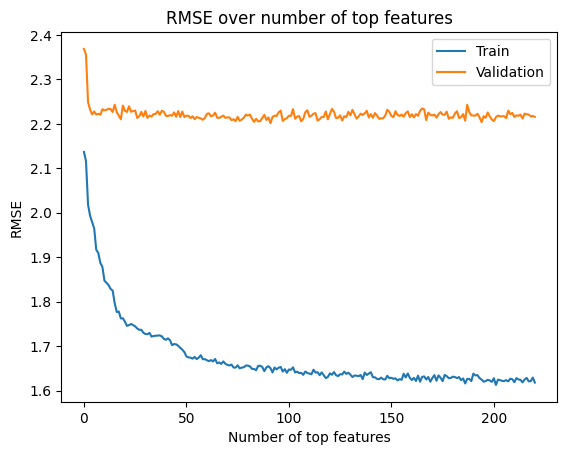

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(root_mean_squared_errors_train.values(), label='Train')
plt.plot(root_mean_squared_errors_val.values(), label='Validation')
plt.legend()
plt.title('RMSE over number of top features')
plt.xlabel('Number of top features')
plt.ylabel('RMSE')
plt.show()

In [10]:
# Find the key with the minimum value
min_key = min(root_mean_squared_errors_val, key=root_mean_squared_errors_val.get)

print("Index with the minimum value:", min_key)
print("Minimum value:", root_mean_squared_errors_val[min_key])

Index with the minimum value: 92
Minimum value: 2.2016111122453483


In [11]:
shp.get_top_features(5)

['bg-0:00', 'p_num_p10', 'bg-0:15', 'bg-0:10', 'bg-0:05']

In [14]:
shp.get_top_features(92)

['bg-0:00',
 'p_num_p10',
 'bg-0:15',
 'bg-0:10',
 'bg-0:05',
 'p_num_p02',
 'hr-0:00',
 'bg-0:20',
 'p_num_p04',
 'p_num_p11',
 'bg-3:00',
 'bg-0:25',
 'hr-0:05',
 'steps-0:00',
 'p_num_p12',
 'cals-0:00',
 'insulin-0:10',
 'insulin-0:25',
 'hour_19',
 'p_num_p21',
 'insulin-0:00',
 'hour_20',
 'insulin-0:30',
 'insulin-0:35',
 'insulin-0:05',
 'hr-0:10',
 'hr-0:15',
 'insulin-0:40',
 'hour_05',
 'bg-0:40',
 'insulin-0:20',
 'insulin-0:15',
 'hour_06',
 'insulin-0:45',
 'p_num_p15',
 'hour_04',
 'bg-0:45',
 'steps-0:10',
 'steps-0:20',
 'hour_22',
 'insulin-0:55',
 'steps-0:15',
 'hour_13',
 'insulin-1:10',
 'insulin-0:50',
 'hour_21',
 'steps-0:25',
 'bg-1:45',
 'hour_23',
 'bg-1:05',
 'cals-2:55',
 'hr-1:00',
 'hour_07',
 'bg-0:30',
 'bg-0:35',
 'hr-0:50',
 'bg-2:00',
 'steps-0:55',
 'insulin-1:15',
 'insulin-1:00',
 'bg-1:35',
 'cals-2:35',
 'steps-0:50',
 'insulin-1:05',
 'bg-1:15',
 'bg-2:05',
 'steps-1:10',
 'insulin-1:30',
 'bg-2:45',
 'hr-3:00',
 'insulin-2:10',
 'bg-1:30',
 '

## Feature importance RidgeCV

In [15]:
# Load and preprocess the train data 
from src.features.tuners import RidgeCVHyperparameterTuner
from sklearn.metrics import root_mean_squared_error

train_and_validation_data = pd.concat([train_data_processed, validation_data_processed])

X = train_and_validation_data.drop(columns=['bg+1:00'])
y = train_and_validation_data['bg+1:00']

tuner = RidgeCVHyperparameterTuner()
tuner.fit(X, y)
model = tuner.get_best_model()

y_log = np.log1p(y)
model.fit(X=X, y=y_log)

y_pred_log = model.predict(X=X)
y_pred = np.expm1(y_pred_log)

root_mean_squared_error(y_true=y, y_pred=y_pred)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_)
}).sort_values(by='Importance', ascending=False)

feature_importance

TypeError: len() of unsized object

In [13]:
from tqdm.notebook import tqdm
import numpy as np

root_mean_squared_errors_train = {}
root_mean_squared_errors_val = {}

X_train = train_data_processed.drop(columns=['bg+1:00'])
y_train = train_data_processed['bg+1:00']

X_val = validation_data_processed.drop(columns=['bg+1:00'])
y_val = validation_data_processed['bg+1:00']

for i in tqdm(range(1, len(feature_importance))):
    selected_features = feature_importance['Feature'].values[:i]
    X_train_loop = X_train[selected_features]
    X_val_loop = X_val[selected_features]
    model = tuner.get_best_model()

    y_train_log = np.log1p(y_train)
    model.fit(X=X_train_loop, y=y_train_log)
    y_train_predict_log = model.predict(X=X_train_loop)
    y_train_predict = np.expm1(y_train_predict_log)

    y_pred_log = model.predict(X=X_val_loop)
    y_pred = np.expm1(y_pred_log)

    root_mean_squared_errors_train[i] = root_mean_squared_error(y_train, y_train_predict)
    root_mean_squared_errors_val[i] = root_mean_squared_error(y_val, y_pred)


  0%|          | 0/221 [00:00<?, ?it/s]

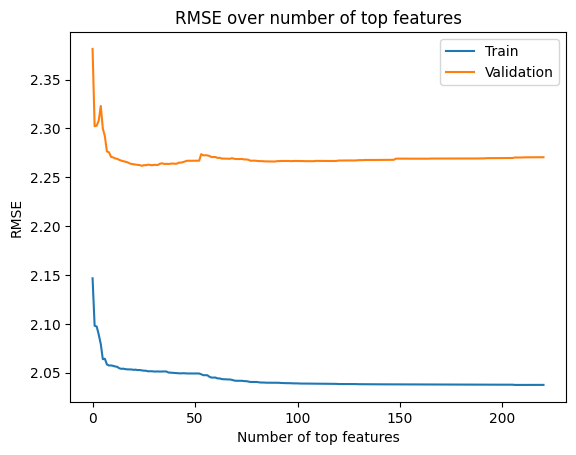

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(root_mean_squared_errors_train.values(), label='Train')
plt.plot(root_mean_squared_errors_val.values(), label='Validation')
plt.legend()
plt.title('RMSE over number of top features')
plt.xlabel('Number of top features')
plt.ylabel('RMSE')
plt.show()

In [16]:
# Find the key with the minimum value
min_key = min(root_mean_squared_errors_val, key=root_mean_squared_errors_val.get)

print("Index with the minimum value:", min_key)
print("Minimum value:", root_mean_squared_errors_val[min_key])

Index with the minimum value: 25
Minimum value: 2.2610437362786016
